In [229]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa

from shapely.geometry import box

import matplotlib.pyplot as plt
import contextily as ctx

In [11]:
import contextlib

def parse_par(par_fp):
    with open(par_fp, 'r') as f:
        lns = f.readlines()
    par = {l.split()[0].strip(':'):l.split()[1] for l in lns if len(l) > 2}

    for k, v in par.items():
        try: par[k] = float(v)
        except: par[k] = v
    return par

def get_width(par):
    cols = [k for k in par.keys() if ('range_samp' in k) or ('width' in k)]
    width = par[cols[0]]
    return width

def gamma_to_numpy(fp, par_fp):
    par = parse_par(par_fp)
    width = get_width(par)
    arr = np.fromfile(fp, '>f4').reshape(-1, int(width))

    return arr, par

def gamma_to_xarray(fp, par_fp = None):
    if not par_fp: par_fp = fp.parent.parent.joinpath('processing', 'Oliktok').with_suffix('.dem_par')
    arr, par = gamma_to_numpy(fp, par_fp)
    dx, dy = par['post_lon'], par['post_lat']
    xs = np.linspace(par['corner_lon'], par['corner_lon'] + dx* arr.shape[1], arr.shape[1])
    ys = np.linspace(par['corner_lat'], par['corner_lat'] + dy* arr.shape[0], arr.shape[0])
    da = xr.DataArray(arr, dims = {'x', 'y'}, coords = {'y': ys, 'x': xs})
    return da.where((da > 0) & (da < 1)).dropna('x', how = 'all').dropna('y', how = 'all')


In [159]:
import numpy as np
from scipy.optimize import curve_fit

def fit_coh_decay_model(cohs, days, tau_guess, bounds, xtol, ftol, gamma_inf_guess = 0.3):
    # https://rowannicholls.github.io/python/curve_fitting/exponential.html

    # Fit the function a * np.exp(b * t) + c to x and y
    params, pcov = curve_fit(lambda t, gamma_inf, tau: gamma_inf + (1 - gamma_inf) * np.exp(- t / tau), days, cohs, p0=(gamma_inf_guess, tau_guess),\
        bounds = bounds, ftol = ftol, xtol = xtol)

    gamma_inf, tau = params

    return gamma_inf, tau, pcov

def decorrelation_temporal_model(t, gamma_inf, tau):
    coherence =  gamma_inf + (1 - gamma_inf) * np.exp(- t / tau)
    return coherence

In [78]:
gdf = gpd.read_file('/Users/rdcrlzh1/Documents/arctic-radarsat2/data/FY24_OLI_UTQ_rsgis_coherance_aois/FY24_OLI_UTQ_rsgis_coherance_aois.shp')
gdf = gdf[gdf.Location == 'Oliktok']

In [187]:
dss = {fp.stem.replace('.cor',''): gamma_to_xarray(fp) for fp in list(Path('/Users/rdcrlzh1/Documents/arctic-radarsat2/data/Oliktok').joinpath('SLA16').rglob('*.cor.geo'))}
# dss= {s: da.expand_dims(time1 =[pd.to_datetime(s.split('_')[0])], time2 =[pd.to_datetime(s.split('_')[1])]) for s, da in dss.items()}
master_date = '2023-08-03_2023-08-27'
for s, da in dss.items():
    dss[s] = da.rio.write_crs('EPSG:4326')
    if s != master_date: da = da.rio.write_crs('EPSG:4326').rio.reproject_match(dss[master_date].rio.write_crs('EPSG:4326'))
    da = da.where((da < 1) & (da > 0))
    dss[s] = da.expand_dims(time1 =[pd.to_datetime(s.split('_')[1])], time2 =[pd.to_datetime(s.split('_')[0])])
ds = xr.combine_by_coords(dss.values(),coords = 'minimal').rio.write_crs('EPSG:4326')

In [330]:
r.geometry.bounds

(-149.88037794631552,
 70.49223325493955,
 -149.87095963276957,
 70.49691451213818)

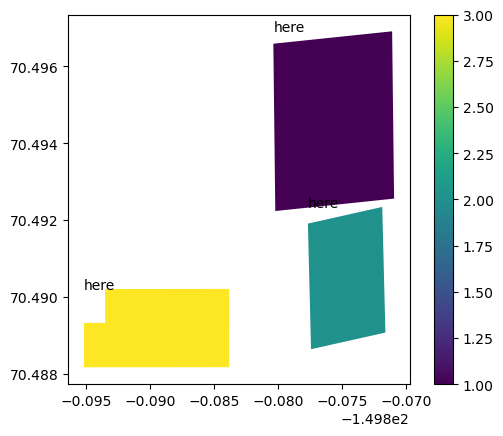

In [331]:
gdf[gdf.Location == 'Oliktok'].plot(column = 'Priority', legend = True)

for i, r in gdf[gdf.Location == 'Oliktok'].iterrows():
    xmin, ymin, xmax, ymax = r.geometry.bounds
    plt.text(xmin, ymax, 'here')

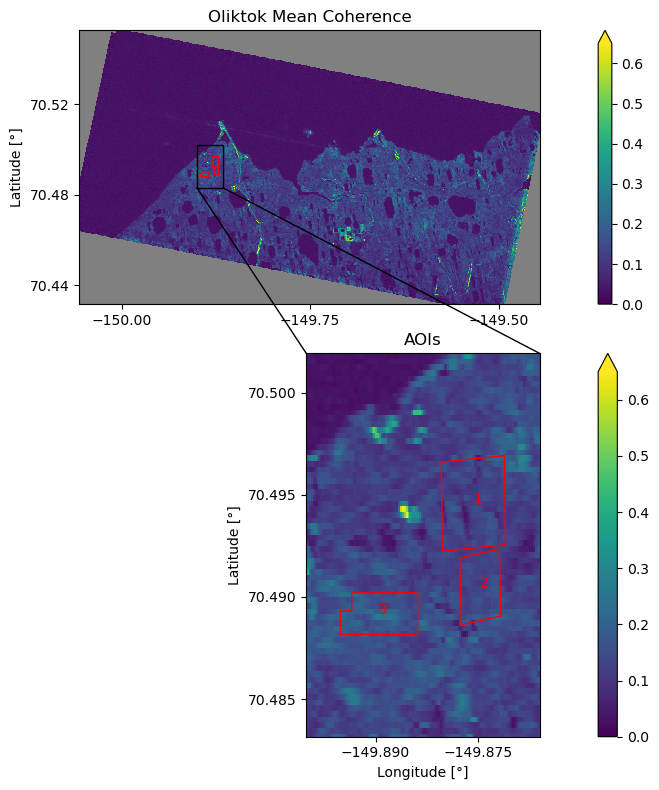

In [368]:
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

fig, axes= plt.subplots(2, 1, figsize = (12, 8), height_ratios= [5, 7])
# dsc = ds.rio.clip(gpd.GeoDataFrame([box(*gdf[gdf.Location == 'Oliktok'].total_bounds)])[0].values, 'EPSG:4326')
# dsc = dsc.where((dsc < 1) & (dsc > 0))
dsc = ds

for ax in axes:
    if ax == axes[0]: dsc.mean(['time1', 'time2']).plot(ax = ax, vmin = 0, vmax = 0.65, add_colorbar=True)
    if ax == axes[1]: dsc.mean(['time1', 'time2']).plot(ax = ax, vmin = 0, vmax = 0.65, add_colorbar=True)
    gdf[gdf.Location == 'Oliktok'].plot(ax = ax, facecolor = "none", edgecolor = 'red')
    ax.ticklabel_format(axis = 'both', style = 'plain',useOffset = False)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.set_ylabel('Latitude [°]')
    ax.set_facecolor("grey")
axes[0].set_xlabel('')
axes[1].set_xlabel('Longitude [°]')
axes[0].set_title('Oliktok Mean Coherence')
axes[1].set_title('AOIs')

xmin, ymin, xmax, ymax = gdf[gdf.Location == 'Oliktok'].total_bounds
buff = 0.005
axes[1].set_xlim(xmin - buff, xmax + buff)
axes[1].set_ylim(ymin - buff, ymax + buff)
width = (xmax + buff) - (xmin - buff)
height = (ymax + buff) - (ymin - buff)
rect = patches.Rectangle((xmin - buff, ymin - buff), width, height, linewidth=1, edgecolor='black', facecolor='none')
# Add the patch to the Axes
axes[0].add_patch(rect)
con1 = ConnectionPatch(xyA=(xmin - buff, ymin - buff), xyB=(xmin - buff, ymax + buff), coordsA="data", coordsB="data", axesA=axes[0], axesB=axes[1], color="black")
axes[0].add_artist(con1)
con1 = ConnectionPatch(xyA=(xmax + buff, ymin - buff), xyB=(xmax + buff, ymax + buff), coordsA="data", coordsB="data", axesA=axes[0], axesB=axes[1], color="black")
axes[0].add_artist(con1)

for i, r in gdf[gdf.Location == 'Oliktok'].iterrows():
    xmin, ymin, xmax, ymax = r.geometry.bounds
    xc, yc = (xmax + xmin) /2  , (ymin + ymax) / 2
    axes[1].text(xc, yc, r.Priority, color = 'red')

plt.tight_layout()
plt.subplots_adjust(hspace=0.15)

/Users/rdcrlzh1/miniforge3/envs/science/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rdcrlzh1/miniforge3/envs/science/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rdcrlzh1/miniforge3/envs/science/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


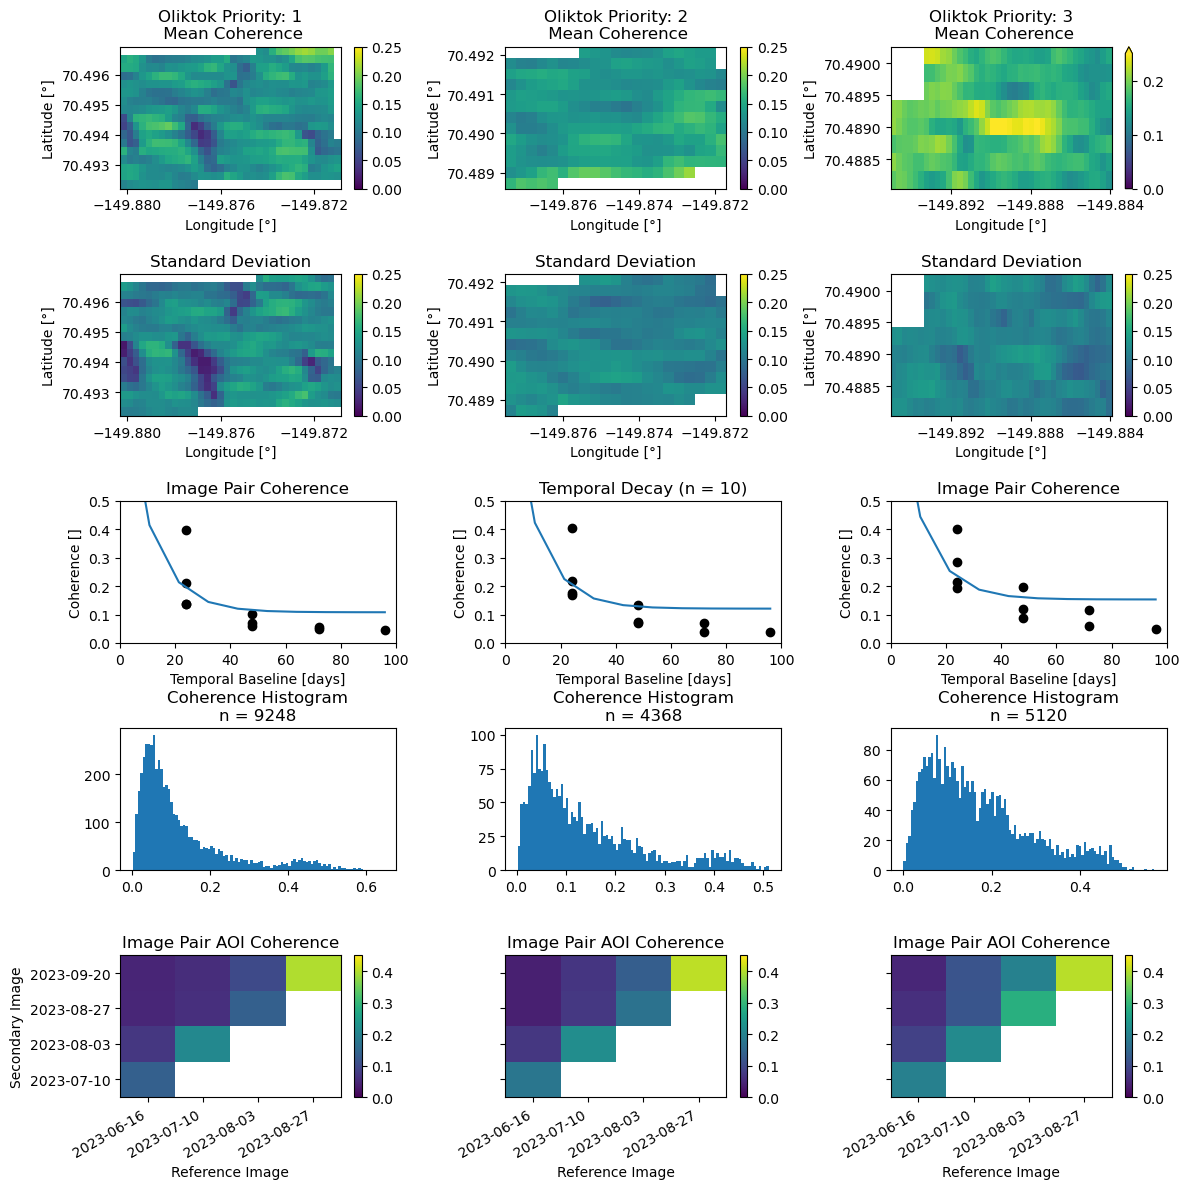

In [364]:
from itertools import product
fig, axes= plt.subplots(5, 3, figsize = (12, 12))
for i, (ind, r) in enumerate(gdf[gdf.Location == 'Oliktok'].iterrows()):
    geom = [r.geometry]
    sub = ds.rio.clip(geom, 'EPSG:4326')
    sub = sub.where((sub > 0) & (sub < 1))

    sub.mean(['time1','time2']).plot(ax = axes[0, i], vmin = 0, vmax = 0.25)
    sub.std(['time1','time2']).plot(ax = axes[1, i], vmin = 0, vmax = 0.25)
    axes[1, i].set_title('Standard Deviation')

    sub.plot.hist(ax = axes[3, i], bins = 100)
    axes[3, i].set_title(f'Coherence Histogram\nn = {sub.size}')

    sub.mean(['x', 'y']).plot(vmax = 0.45, vmin = 0, ax= axes[4, i])
    axes[4, i].set_xlabel('Reference Image')
    axes[4, 0].set_ylabel('Secondary Image')
    for ax in axes[4, 1:]: ax.set_ylabel(''); ax.set_yticklabels([])
    
    dts = []
    cors = []
    for t1, t2  in product(sub.time1.values, sub.time2.values):
        cor = sub.sel(time1 = t1, time2 = t2).mean()
        dt = t1 - t2
        axes[2, i].scatter(pd.Timedelta(dt).days, cor, color = 'black')
        axes[2, i].set_xlim(0, 100)
        axes[2, i].set_ylim(0, 0.5)
        dts.append(pd.Timedelta(dt).days)
        cors.append(cor.values.ravel()[0])

    ix = (~np.isnan(cors)) & (~np.isnan(dts))
    cors, dts = np.array(cors)[ix], np.array(dts)[ix]
    gamm_inf, tau, _ = fit_coh_decay_model(cors, dts, 5, [[0,0], [20,30]], 1, 1, gamma_inf_guess=0.05)
    x = np.linspace(0, np.max(dts), 10)
    y = decorrelation_temporal_model(x, gamm_inf, tau)
    axes[2, i].plot(x, y)
    
    axes[0, i].set_title(f'Oliktok Priority: {r.Priority}\n Mean Coherence')

    axes[2, i].set_title('n = 10')
    axes[2, i].set_xlabel('Temporal Baseline [days]')
    axes[2, i].set_ylabel('Coherence []')
    axes[2, i].set_title('Image Pair Coherence')
    axes[4, i].set_xticks(sub.time2); axes[4, i].set_yticks(sub.time1)
    axes[4, i].set_title('Image Pair AOI Coherence')

axes[2, 1].set_title('Temporal Decay (n = 10)')
for ax in axes[:2, :].ravel(): 
    ax.ticklabel_format(axis = 'both', style = 'plain',useOffset = False); ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_xlabel('Longitude [°]')
    ax.set_ylabel('Latitude [°]')
# for ax in axes[1, :].ravel(): ax.set_xticks(sub.time2); ax.set_yticks(sub.time1)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)